In [1]:
import os
import sys
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging
from torch.utils.data import DataLoader
import multiprocessing
import tqdm
import ast
from annoy import AnnoyIndex
import cv2
import torchvision.transforms as transforms

from torchvision import transforms


In [2]:
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))

In [3]:
sys.path.append(os.path.join(dir_path, "src"))

In [4]:
from data_module import ImageDataModule
from resnet import Resnet50
from utils import collate_batch
from dataset import ImageDataset

/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ckpt = os.path.join(dir_path, "notebooks","lightning_logs","version_39","checkpoints","epoch=7-step=1952.ckpt")
# ckpt = os.path.join(dir_path, "notebooks","lightning_logs","version_40","checkpoints","epoch=41-step=10248.ckpt")

In [6]:
model = Resnet50.load_from_checkpoint(ckpt, embedding_size=512, num_classes=19)

/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/main/.local/share/virtualenvs/cosc525_final_project-aJH_ag1x/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def load_image(file):
        path = os.path.join(dir_path, "images", "raw")
        image = cv2.imread(f"{path}/{file}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
        )
        transformations = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]) 
        image = transformations(image)
        return image.unsqueeze(0) # add a batch channel

In [8]:
def extract_embedding(model, image):
    model.eval()
    with torch.no_grad():
        embedding = model(image)
    return embedding[0]


## Load Search index

In [9]:
embedding_size = 512
annoy_index_file = 'annoy_index.ann'

In [10]:
loaded_annoy_index = AnnoyIndex(embedding_size, 'euclidean')
loaded_annoy_index.load(annoy_index_file)

True

## Load index DF

In [11]:
index_df = pd.read_csv("metadata.csv", index_col=0)

In [12]:
index_df

,genre,image_name
0,['Animation'],qNBAXBIQlnOThrVvA6mA2B5ggV6.jpg
1,['Drama'],vJU3rXSP9hwUuLeq8IpfsJShLOk.jpg
2,['Science Fiction'],t6HIqrRAclMCA60NsSmeqe9RmNV.jpg
3,['Animation'],qVdrYN8qu7xUtsdEFeGiIVIaYd.jpg
4,['Comedy'],swzMoIVn6xjB857ziYJ8KBV440g.jpg
...,...,...
9734,['Comedy'],vkF8VLrazGtk9OjdEhihG6kKAhP.jpg
9735,['Thriller'],yw8x2i3vaHZZzpvqvF75E8q2N6M.jpg
9736,['Drama'],bFOmE3zCFU01TuomOOwClAWdvOD.jpg
9737,['Action'],kziBJGQFo9f0Vkj9s37qI0G9I0I.jpg


## Query for embedding

### Will query most popular movies
reference: https://www.themoviedb.org/movie?language=en-US


In [13]:
super_mario_bros = "qNBAXBIQlnOThrVvA6mA2B5ggV6.jpg"

In [138]:
clown = "uNvbakoHyQYqeWanOw3mF3troWU.jpg"

In [34]:
contagion = "qL0IooP0bjXy0KXl9KEyPo22ll0.jpg"

In [24]:
girl_with_dragon = "zqDopwg7XQ4IfFX2dRlQCT1SwMG.jpg"

In [35]:
im = load_image(contagion)

In [36]:
query_embedding = extract_embedding(model, im)

In [37]:
query_embedding

tensor([ 1.3709e-02, -6.6297e-02, -4.1787e-02, -6.5639e-02,  3.4138e-03,
         7.7447e-02, -1.6575e-02, -4.0273e-02, -5.1478e-03,  4.4031e-02,
        -2.5560e-02, -5.4592e-02, -8.4497e-02, -3.3897e-02, -5.6259e-02,
        -2.2432e-02, -5.6808e-02, -4.5812e-03, -4.0356e-02, -7.5856e-03,
        -5.1242e-02,  1.7733e-03,  5.6137e-02, -6.8394e-02,  6.4622e-02,
         8.0704e-02, -3.7698e-02,  1.3867e-02, -1.2619e-02, -1.0404e-01,
        -5.6294e-02,  8.2866e-03,  4.1230e-02,  2.4163e-02,  1.4559e-02,
        -1.7913e-02, -3.6934e-02, -3.1056e-02, -4.2675e-02,  9.0896e-02,
         2.9045e-02,  3.0594e-03, -2.4198e-02,  1.5158e-03,  2.3588e-02,
        -5.3209e-02, -2.4413e-02, -4.9098e-02, -7.4946e-02,  1.9398e-02,
         3.2882e-02, -9.9242e-02,  1.5374e-02, -1.9821e-02, -6.6023e-02,
        -4.2383e-03,  9.6465e-03, -2.4558e-03,  4.3455e-02,  1.8977e-02,
        -2.5834e-03,  9.3455e-03, -1.0546e-02,  8.2355e-03,  3.8063e-02,
        -5.2557e-02, -6.1067e-02, -9.2172e-02,  7.8

In [38]:
query_embedding.shape

torch.Size([512])

In [39]:
num_neighbors = 5

In [40]:
nearest_indices = loaded_annoy_index.get_nns_by_vector(query_embedding, num_neighbors)

In [41]:
nearest_indices

[2802, 6006, 8077, 2808, 2517]

In [42]:
index_df.iloc[5129]

genre                             ['Romance']
image_name    bycmMhO3iIoEDzP768sUjq2RV4T.jpg
Name: 5129, dtype: object

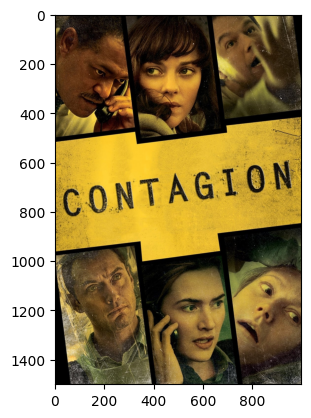

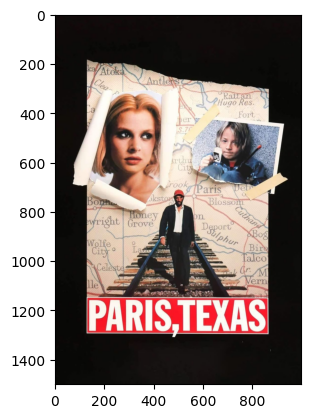

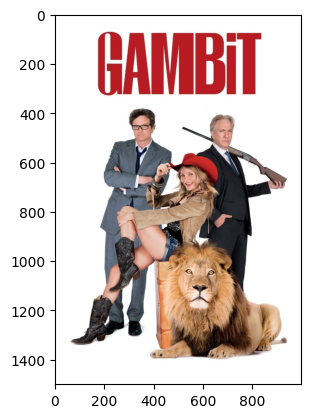

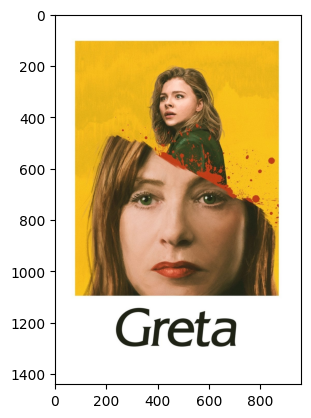

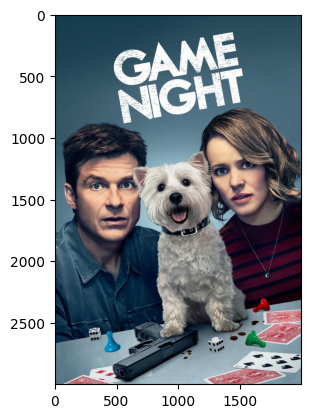

In [43]:
for index in nearest_indices:
    file = index_df.iloc[index]["image_name"]
    path = os.path.join(dir_path, "images", "raw")
    image = cv2.imread(f"{path}/{file}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()